In [1]:
from pathlib import Path
import scipy.stats as ss
import pandas as pd
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import torch

In [2]:
%load_ext autoreload
%autoreload 2
from notunet import NotUNet

## Load data
I used the sliding window dataset here

In [3]:
class dataset_toyzero(torch.utils.data.Dataset):
    """
    LS4GAN dataset
    """
    def __init__(
        self, 
        paths, *,
        clip=None,
        batch_size=1, 
        valid_fraction=.2,
        max_num=None,
    ):
        super(dataset_toyzero, self).__init__()    
        
        self.clip = clip
        
        self.image_fnames = []
        for path in paths:
            self.image_fnames += list(Path(path).glob('*npz'))
        self.image_fnames = np.array(self.image_fnames)
        
        indices = np.arange(len(self.image_fnames))
        np.random.shuffle(indices)
        if max_num is not None:
            indices = indices[:max_num]
        valid_size = int(len(indices) * valid_fraction)
        train_size = len(indices) - valid_size
        indices_train = indices[:train_size]
        indices_valid = indices[train_size:]
        print(f'train example: {train_size} / {len(indices)}')
        print(f'valid example: {valid_size} / {len(indices)}')

        self.data_loaders = {}
        for split, I in zip(['train', 'valid'], [indices_train, indices_valid]):
            datum = np.array(list(map(self._load_file, self.image_fnames[I])))
            loader = torch.utils.data.DataLoader(datum, batch_size=batch_size, shuffle=True)
            self.data_loaders[split] = loader
    
    def _load_file(self, fname):
        datum = np.load(fname)
        datum = datum[datum.files[0]]
        if self.clip is not None:
            datum = datum[:self.clip[0], :self.clip[1]]
        mode = ss.mode(datum, axis=None)[0][0]
        datum -= mode
        return np.expand_dims(np.float32(datum), 0)
    
    def get_split(self, split):
        return self.data_loaders[split]

    def get_splits(self):
        return self.data_loaders['train'], self.data_loaders['valid']

In [7]:
paths = [
    Path(f'/sdcc/u/yhuang2/PROJs/GAN/datasets/ls4gan/toyzero_cropped/toyzero_2021-06-29_safi_U/trainA/'),
    Path(f'/sdcc/u/yhuang2/PROJs/GAN/datasets/ls4gan/toyzero_cropped/toyzero_2021-06-29_safi_U/trainB/')
]

ds = dataset_toyzero(
    paths, 
    clip=[128, 128], 
    batch_size=20, 
    valid_fraction=.4, 
    max_num=2000
)
train_loader, valid_loader = ds.get_splits()
print(f'Number of batches:\
    \n\ttrain = {len(train_loader)}\
    \n\tvalidation = {len(valid_loader)}')

train example: 1200 / 2000
valid example: 800 / 2000
Number of batches:    
	train = 60    
	validation = 40


## The density of the dataset
Let calculated the $\ell_1$ norm of the data.
This can serve as baseline.
That is, if we get $\ell_1$ loss approximately equaling the $\ell_1$ loss, we know it is fail 

In [23]:
l1norms = []
for X in valid_loader:
    l1norm = X.abs().sum() / np.prod(X.shape)
    l1norms.append(l1norm.numpy())

l1norm_mean = np.mean(l1norms)
l1norm_std = np.std(l1norms)
print(f'l1norm mean = {l1norm_mean:.3f}, l1norm std = {l1norm_std:.3f}')

l1norm mean = 0.283, l1norm std = 0.048


## Iterative training (Don't run here!)
I don't quite master recursion and hence I modify Dmitrii's recursive training to an iterative one

**Don't** run it here, since it can be very time consuming when depth_seed is big.
I have a python script which can be used to submit job.

In [8]:
def train(
    model, 
    train_loader, 
    valid_loader, 
    epochs,
    lr=1e-4,
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)
    for e in range(epochs):
        train_loss = 0
        train_len = len(train_loader)
        for x in train_loader:
            x = x.cuda()
            pred = model(x)
            loss = loss_fn(pred, x)
            train_loss += loss.item()
            # back-propagate
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss /= train_len

        valid_loss = 0
        valid_len = len(valid_loader)
        for x in valid_loader:
            x = x.cuda()
            pred = model(x)
            loss = loss_fn(pred, x)
            valid_loss += loss.item()
        valid_loss /= valid_len    
        scheduler.step(valid_loss)

        for param_group in optimizer.param_groups:
            lr = param_group['lr']
            break

        print(f'{e + 1}/{epochs}, train = {train_loss:.6f}, valid = {valid_loss:.6f}, lr={lr:.3e}')

In [12]:
model_pt_folder = 'model_pt'
depth_seed = 16
starting_blocks = 2
blocks = 6
epochs = 200
loss_fn = torch.nn.L1Loss(reduction='mean')

prev_model = NotUNet(		
    input_channels=1, 
	depth_seed=depth_seed, 
	blocks=starting_blocks,
	growth='constant', 
	activation='relu'
).cuda()

# Train the previous model:
print(f'Training model {starting_blocks}')
train(prev_model, train_loader, valid_loader, epochs, lr=1e-4)
pt_fname = f'{model_pt_folder}/notunet_{depth_seed}_{starting_blocks}.pt'
torch.save(prev_model.state_dict(), pt_fname)


for b in range(starting_blocks + 1, blocks + 1):
    transferable_params = prev_model.get_transferable_params()
    
    # get a model of 1 more block
    model = NotUNet(		
        input_channels=1, 
        depth_seed=depth_seed, 
        blocks=b,
        growth='constant', 
        activation='relu'
    ).cuda()
    
    # load transferable parameters
    model.load_transferable_params(transferable_params)
    
    # Train the newly added blocks while freezing the loaded blocks 
    print(f'\nPretrain training model {b}, newly added blocks')
    model.make_lower_subnetwork_trainable(False)
    train(model, train_loader, valid_loader, int(epochs // 4))
    
    # make all layers trainable
    print(f'\nTraining full model {b}')
    model.make_lower_subnetwork_trainable(True)
    train(model, train_loader, valid_loader, epochs, lr=1e-4)
    
    pt_fname = f'{model_pt_folder}/notunet_{depth_seed}_{b}.pt'
    torch.save(model.state_dict(), pt_fname)
    
    prev_model = model

## Collect results and visualize

In [13]:
result_map = {
    'block': [], 
    'depth seed': [], 
    'compression ratio': [], 
    'valid loss': [], 
    'train loss': []
}
for pt in Path('model_pt').glob('*pt'):
    depth_seed, block = list(map(int, pt.stem.split('_')[-2:]))
    model = NotUNet(		
        input_channels=1, 
        depth_seed=depth_seed, 
        blocks=block,
        growth='constant', 
        activation='relu'
    ).cuda()
    model.load_state_dict(torch.load(pt))
    model.eval()
    
    compression_ratio = 4**(block + 1) / depth_seed
    
    with torch.no_grad():
        valid_loss = 0
        valid_len = len(valid_loader)
        for x in valid_loader:
            x = x.cuda()
            pred = model(x)
            loss = loss_fn(pred, x)
            valid_loss += loss.item()
        valid_loss /= valid_len
        
        train_loss = 0
        train_len = len(train_loader)
        for x in train_loader:
            x = x.cuda()
            pred = model(x)
            loss = loss_fn(pred, x)
            train_loss += loss.item()
        train_loss /= train_len
    
    result_map['block'].append(block + 1)
    result_map['depth seed'].append(depth_seed)
    result_map['compression ratio'].append(compression_ratio)
    result_map['valid loss'].append(valid_loss)
    result_map['train loss'].append(train_loss)
    
    print(f'{pt}: train={train_loss:.6f}, valid={valid_loss:.6f}')

model_pt/notunet_32_3.pt: train=0.037846, valid=0.037330
model_pt/notunet_32_4.pt: train=0.070898, valid=0.072561
model_pt/notunet_32_2.pt: train=0.026524, valid=0.026109
model_pt/notunet_16_2.pt: train=0.031314, valid=0.030710
model_pt/notunet_16_3.pt: train=0.065080, valid=0.065908
model_pt/notunet_16_4.pt: train=0.101376, valid=0.104509
model_pt/notunet_64_2.pt: train=0.026454, valid=0.026061
model_pt/notunet_64_3.pt: train=0.026563, valid=0.026170
model_pt/notunet_64_4.pt: train=0.062858, valid=0.064711
model_pt/notunet_64_5.pt: train=0.103247, valid=0.100612
model_pt/notunet_32_5.pt: train=0.114854, valid=0.111854
model_pt/notunet_16_5.pt: train=0.289065, valid=0.282793
model_pt/notunet_128_2.pt: train=0.029559, valid=0.028941
model_pt/notunet_128_3.pt: train=0.030706, valid=0.030145
model_pt/notunet_128_4.pt: train=0.046012, valid=0.044789
model_pt/notunet_256_2.pt: train=0.024758, valid=0.024263
model_pt/notunet_128_5.pt: train=0.107620, valid=0.102203
model_pt/notunet_128_6.pt:

In [14]:
result_df = pd.DataFrame(data=result_map).sort_values(by=['compression ratio', 'valid loss']).reset_index(drop=True)
result_df.to_csv('model_pt/results.csv', index=False)

### Loss v.s. total blocks
The parameter blocks is more precisely the number of *additional* blocks to the basic encoder/decoder. 
Total blocks is parameter blocks plus one.

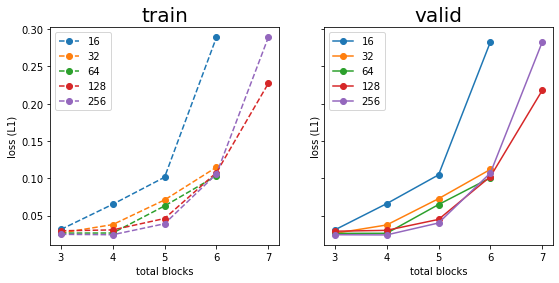

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

for ax, category, style in zip(axes, ['train', 'valid'], ['o--', 'o-']):
    for name, group in result_df.groupby(by='depth seed'):
        blocks = group['block'].values
        cr = group['compression ratio'].values
        loss = group[f'{category} loss'].values
        ax.plot(blocks, loss, style, label=name)
        ax.set_title(f'{category}', fontsize=20)
        ax.legend()
        ax.set_xlabel('total blocks')
        ax.set_ylabel('loss (L1)')

### Loss v.s. Comopression ratio 

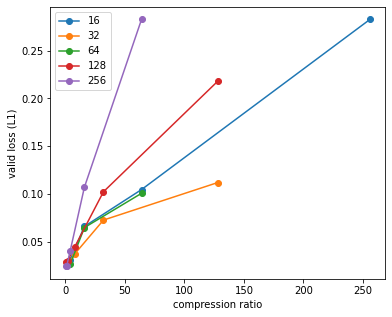

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
cr = result_df['compression ratio'].values
loss = result_df['valid loss'].values
for name, group in result_df.groupby(by='depth seed'):
    group = group.sort_values(by='compression ratio')
    cr = group['compression ratio'].values
    loss = group['valid loss'].values
    ax.plot(cr, loss, 'o-', label=f'{name}')
    ax.set_xlabel('compression ratio')
    ax.set_ylabel('valid loss (L1)')
plt.legend()

### Loss v.s. Comopression ratio (zoom-in)

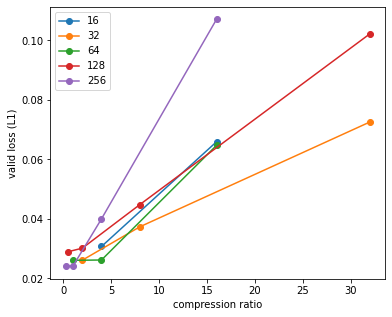

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
cr = result_df['compression ratio'].values
loss = result_df['valid loss'].values
for name, group in result_df.groupby(by='depth seed'):
    group = group.sort_values(by='compression ratio')
    # zoom in
    group = group[group['compression ratio'] <= 32]
    cr = group['compression ratio'].values
    loss = group['valid loss'].values
    ax.plot(cr, loss, 'o-', label=f'{name}')
    ax.set_xlabel('compression ratio')
    ax.set_ylabel('valid loss (L1)')

plt.legend()

### Loss v.s. Comopression ratio (zoom-in, again)

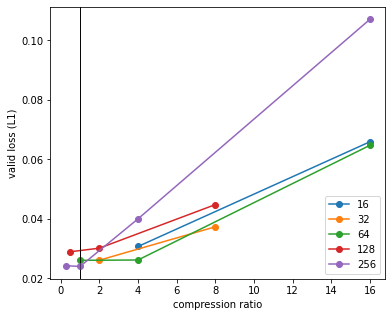

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
cr = result_df['compression ratio'].values
loss = result_df['valid loss'].values
for name, group in result_df.groupby(by='depth seed'):
    group = group.sort_values(by='compression ratio')
    # zoom in
    group = group[group['compression ratio'] <= 16]
    cr = group['compression ratio'].values
    loss = group['valid loss'].values
    ax.plot(cr, loss, 'o-', label=f'{name}')
    ax.set_xlabel('compression ratio')
    ax.set_ylabel('valid loss (L1)')
    ax.axvline(1, c='k', linewidth=.5)

plt.legend()

### Original, reconstructed, and difference

In [19]:
def plot(model_pt, X, save_fname=None, title=None, cmap='bwr'):
    depth_seed, block = list(map(int, model_pt.stem.split('_')[-2:]))
    model = NotUNet(		
        input_channels=1, 
        depth_seed=depth_seed, 
        blocks=block,
        growth='constant', 
        activation='relu'
    ).cuda()
    model.load_state_dict(torch.load(model_pt))
    model.eval()
    
    with torch.no_grad():
        Y = model(X)
    # loss = loss_fn(Y, X)
    
    num_samples, ncols, figer_width = len(X), 3, 3.3
    fig, axes = plt.subplots(
        num_samples, ncols, 
        figsize=(figer_width * ncols, figer_width * num_samples * .9),
        sharex=True,
        sharey=True
    )

    for x, y, ax_row in zip(X, Y, axes):
        x = x.squeeze().cpu().detach().numpy()
        y = y.squeeze().cpu().detach().numpy() 
        d = y - x
        
        vmin = min(x.min(), y.min(), d.min())
        vmax = max(x.max(), y.max(), d.max())
        divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

        ax = ax_row[0]
        ax.set_aspect(1)
        im = ax.pcolormesh(x, cmap=cmap, norm=divnorm)
        # divider = make_axes_locatable(ax)
        # cax = divider.append_axes('right', size='5%', pad=0.1)
        # fig.colorbar(im, cax=cax, orientation='vertical')

        ax = ax_row[1]
        ax.set_aspect(1)
        im = ax.pcolormesh(y, cmap=cmap, norm=divnorm)
        # divider = make_axes_locatable(ax)
        # cax = divider.append_axes('right', size='5%', pad=0.1)
        # fig.colorbar(im, cax=cax, orientation='vertical')

        ax = ax_row[2]
        ax.set_aspect(1)
        im = ax.pcolormesh(d, cmap=cmap, norm=divnorm)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax, orientation='vertical')
    
    if title is not None:
        fig.suptitle(f'{title}', fontsize=20)
    plt.tight_layout()
    
    if save_fname is not None:
        plt.savefig(save_fname, dpi=600, transparent=True)
        
    plt.show()
    plt.close()

model_pt/notunet_32_3.pt


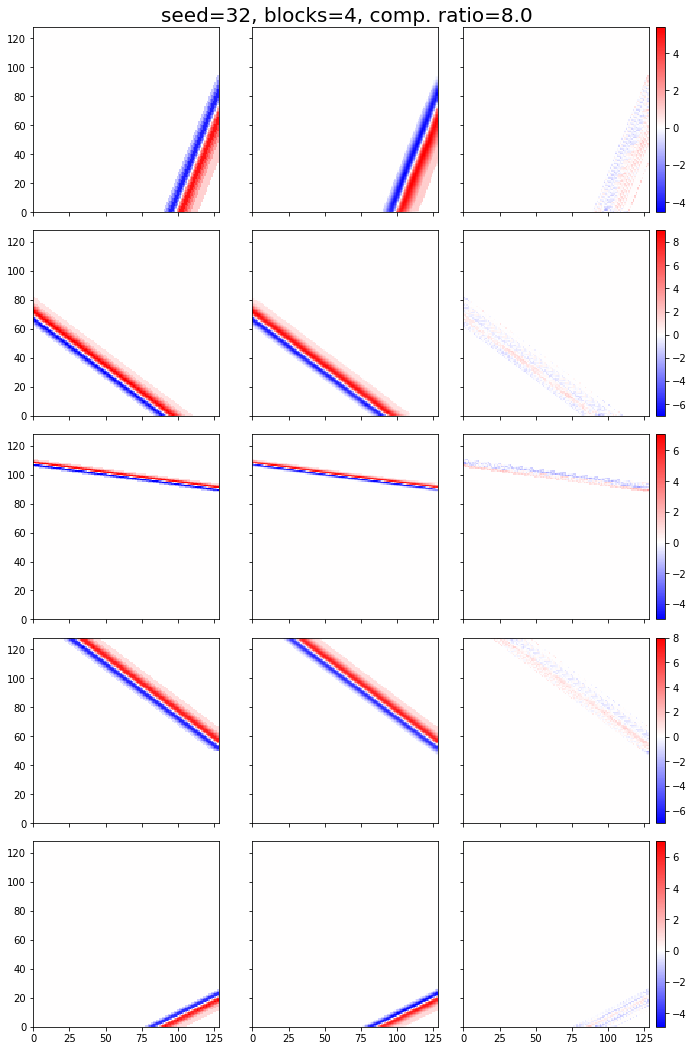

model_pt/notunet_32_4.pt


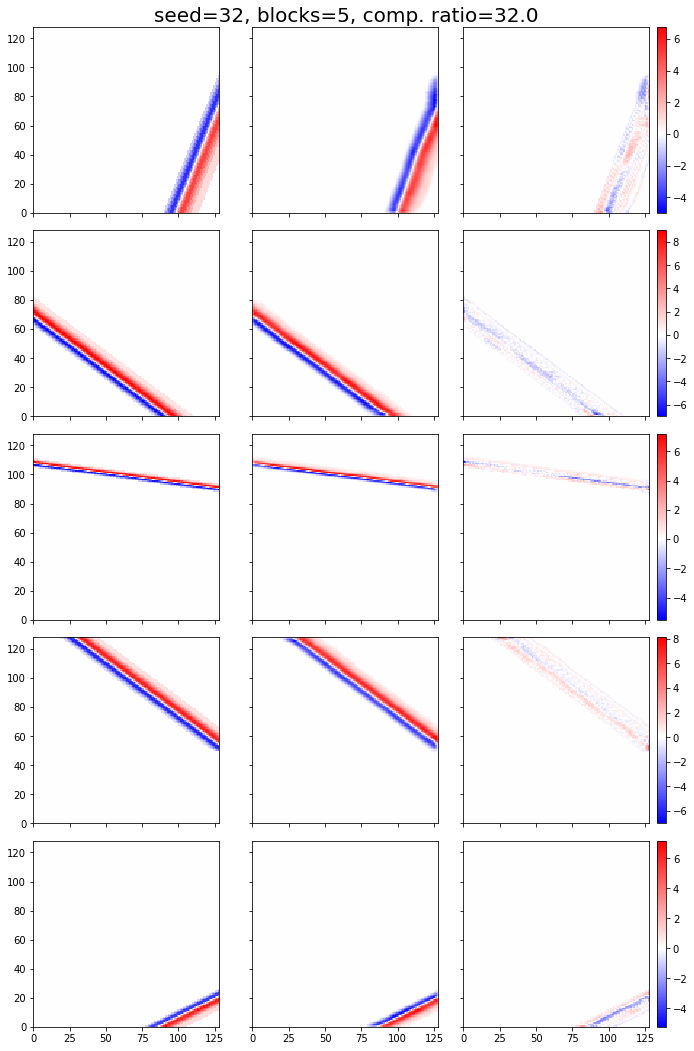

model_pt/notunet_32_2.pt


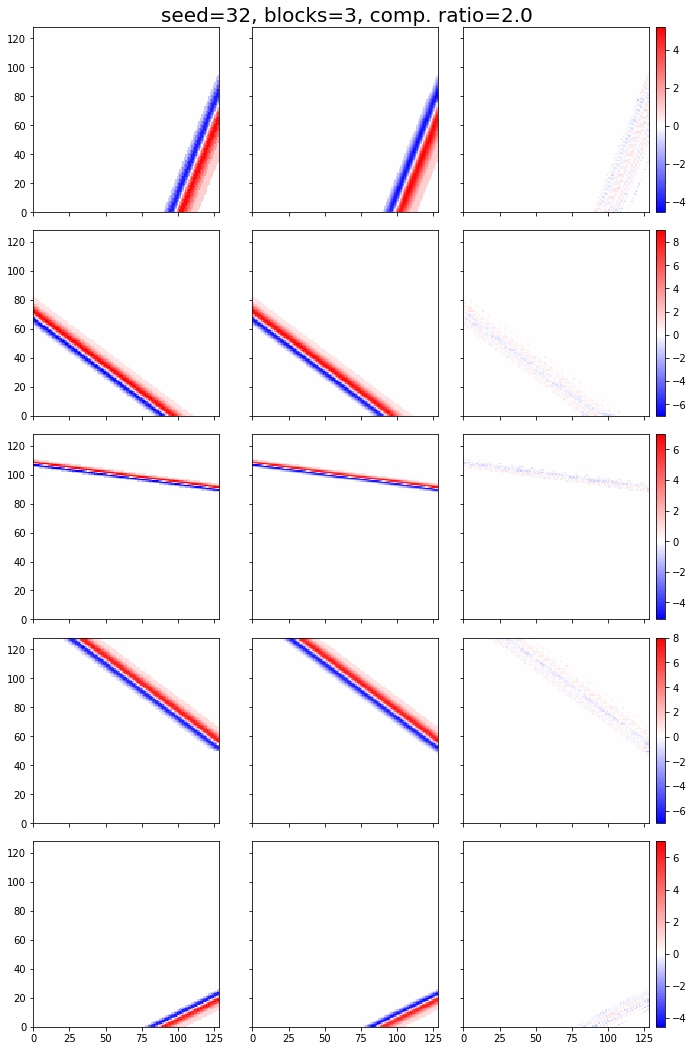

model_pt/notunet_16_2.pt


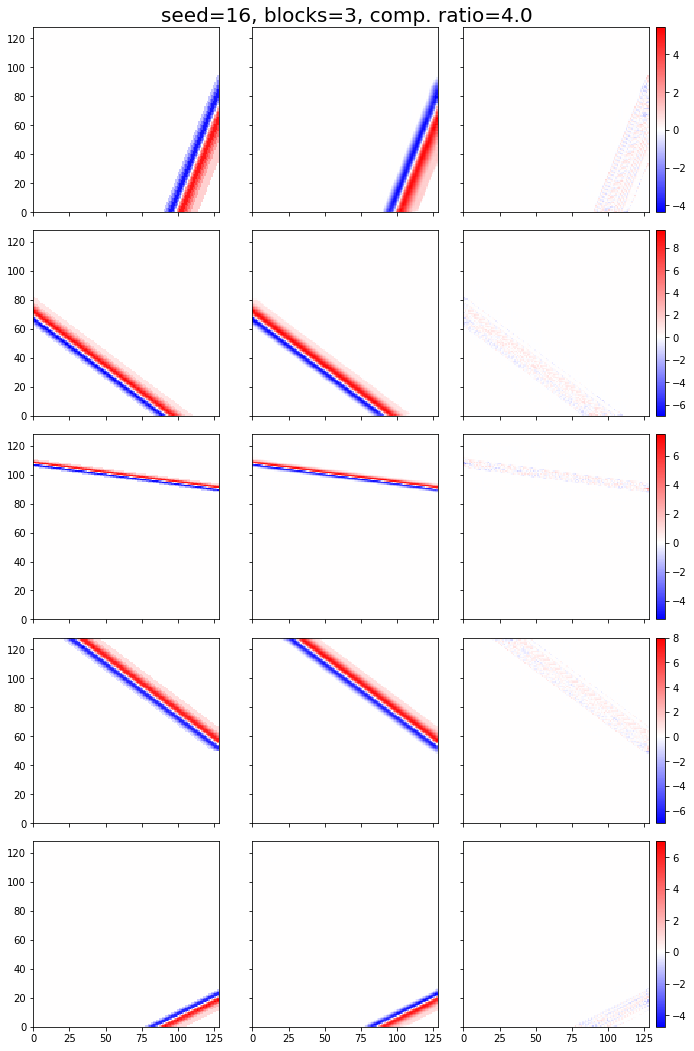

model_pt/notunet_16_3.pt


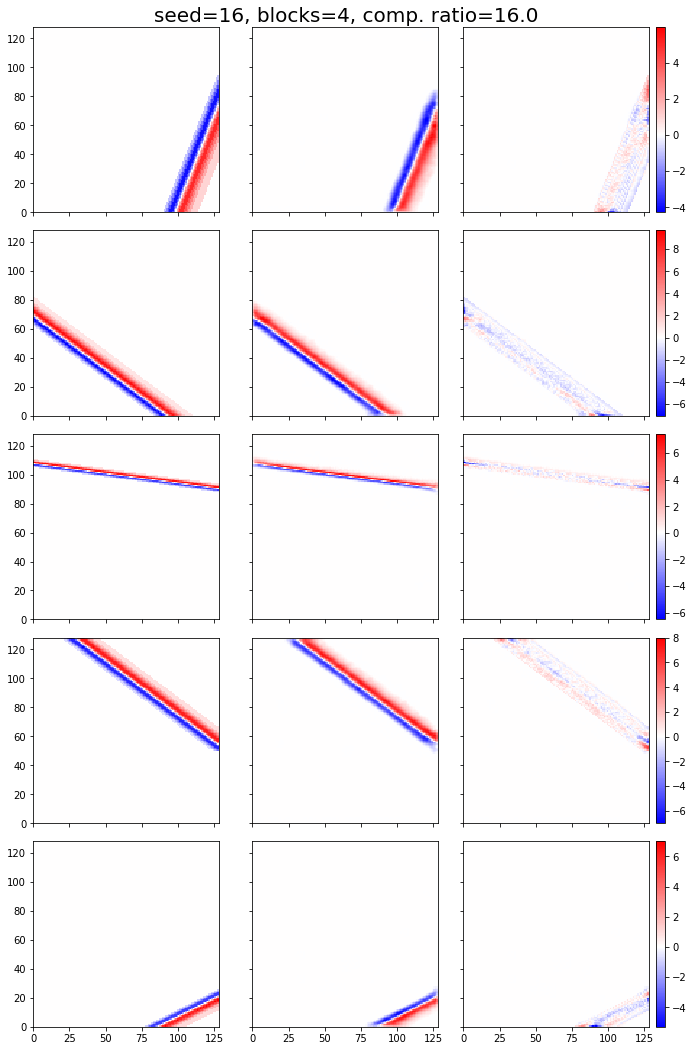

model_pt/notunet_16_4.pt


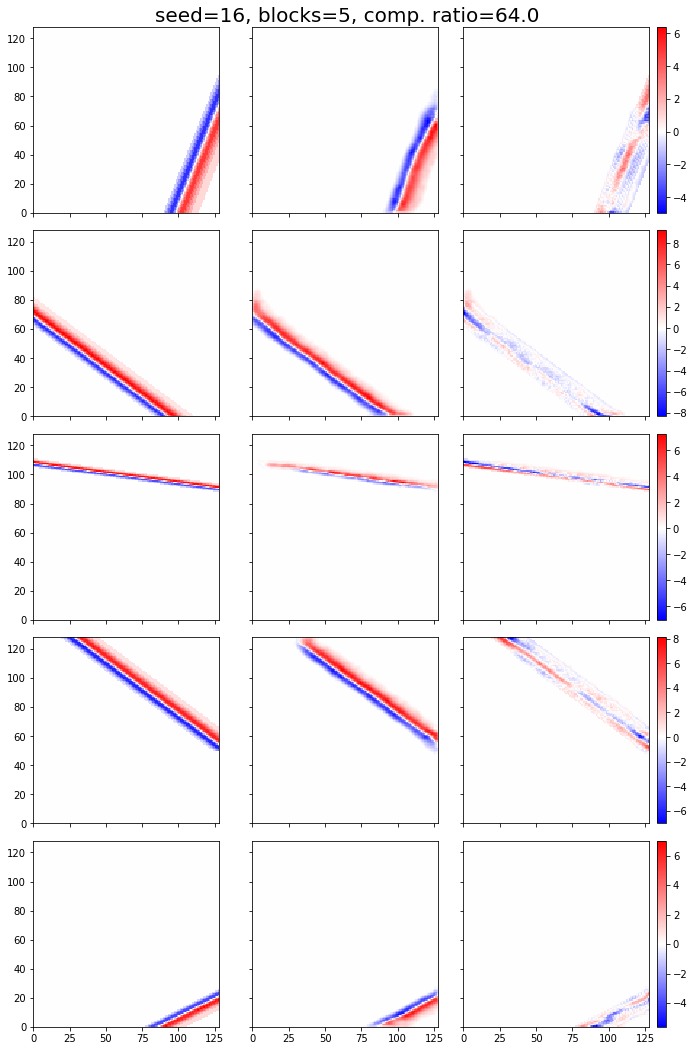

model_pt/notunet_64_3.pt


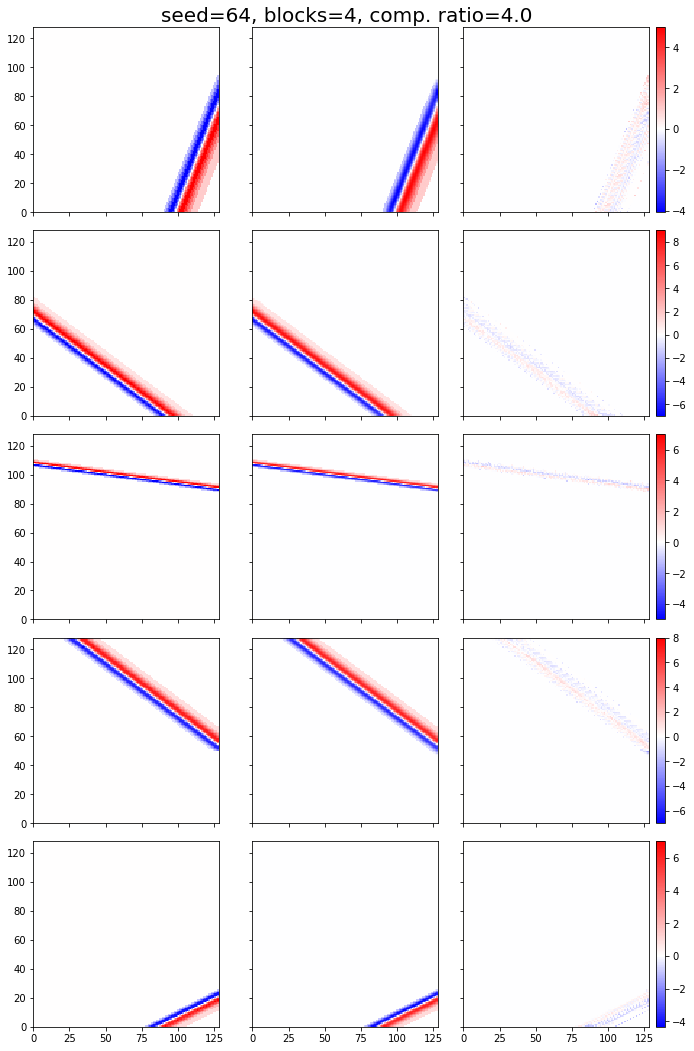

model_pt/notunet_64_4.pt


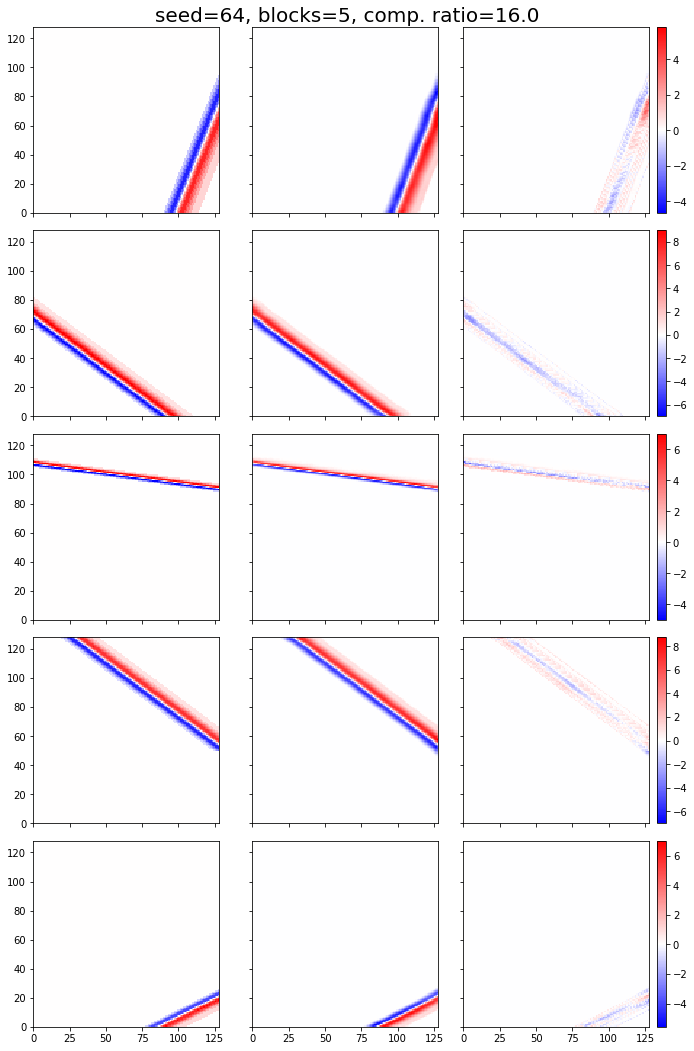

model_pt/notunet_64_5.pt


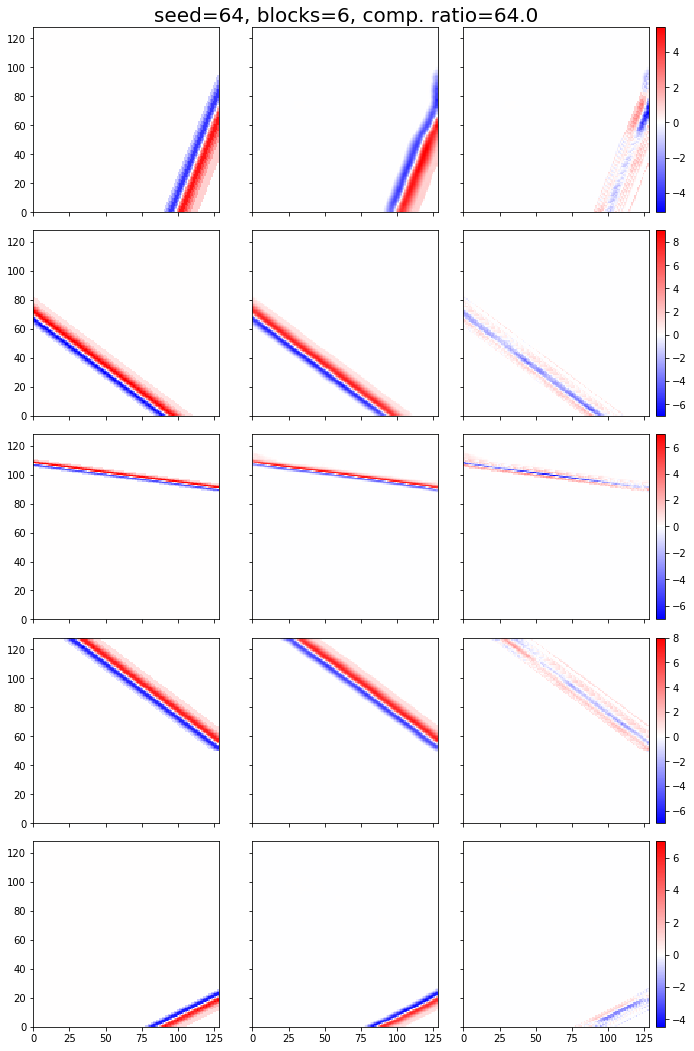

model_pt/notunet_32_5.pt


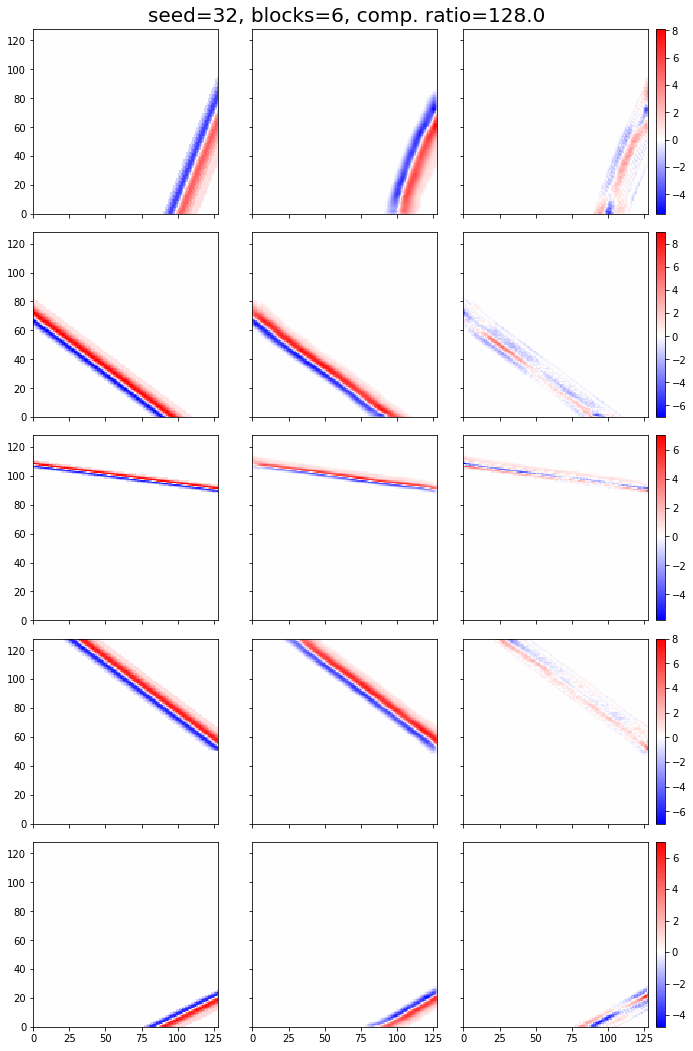

model_pt/notunet_16_5.pt


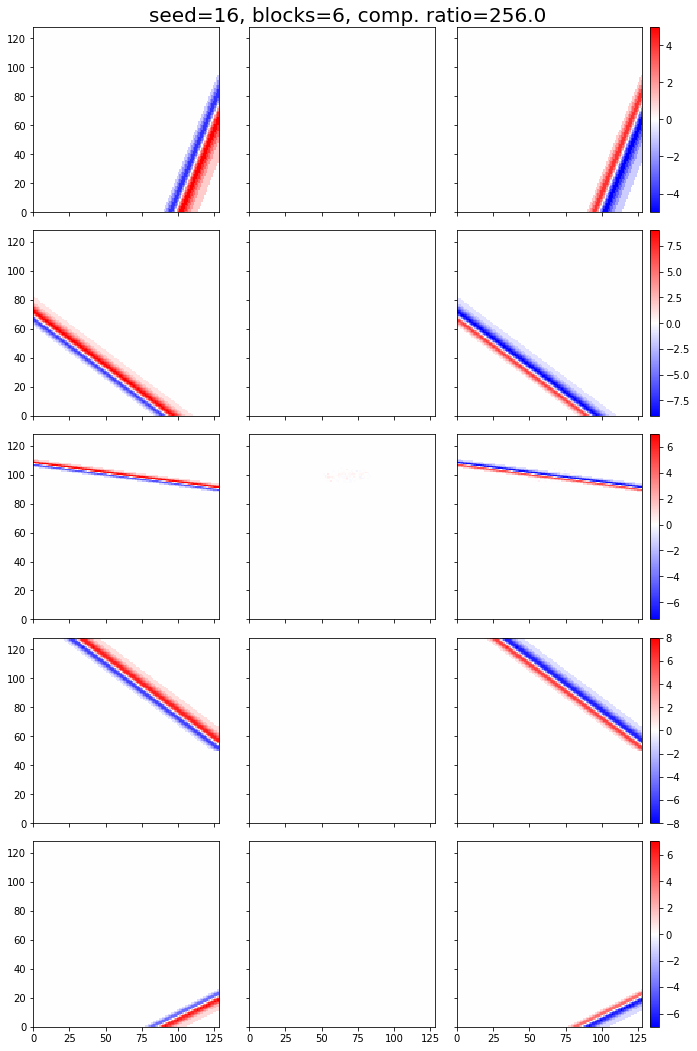

model_pt/notunet_128_3.pt


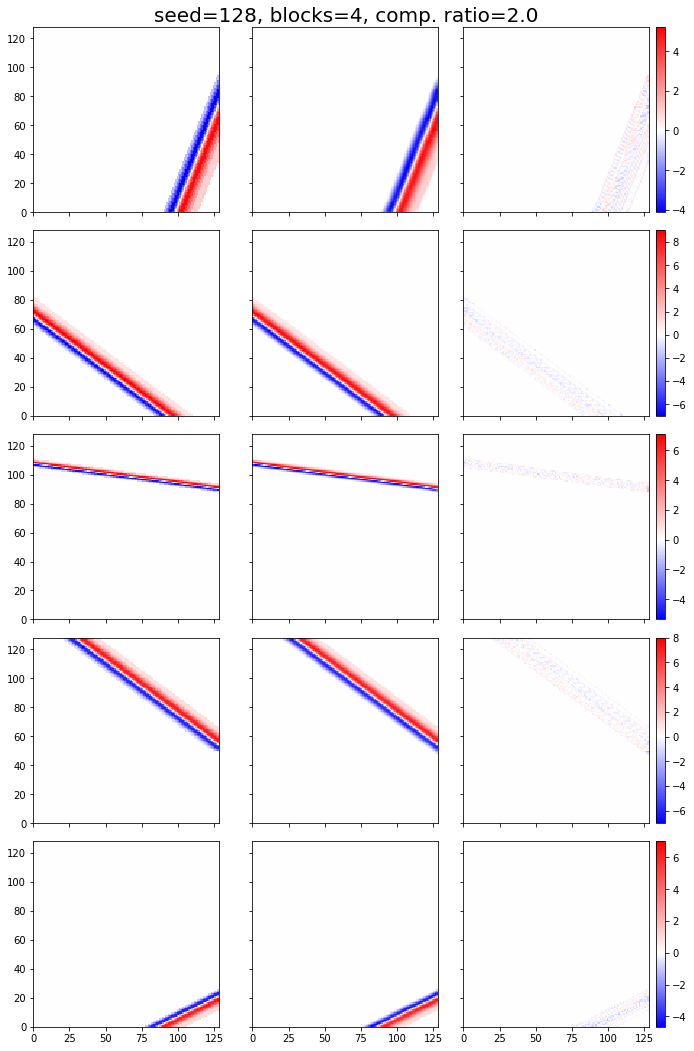

model_pt/notunet_128_4.pt


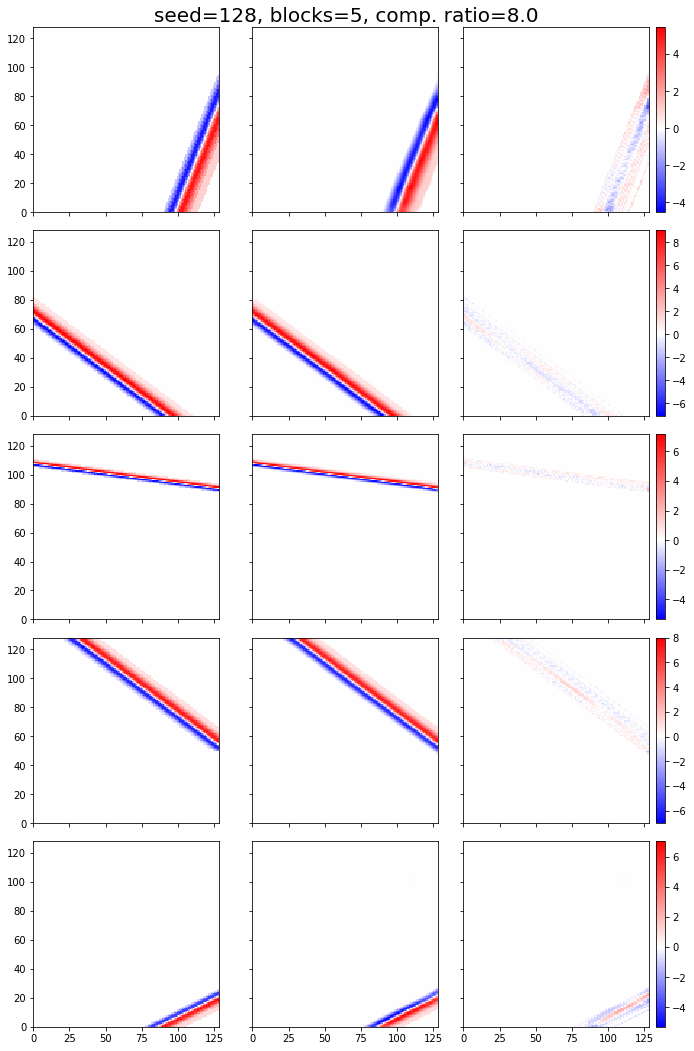

model_pt/notunet_128_5.pt


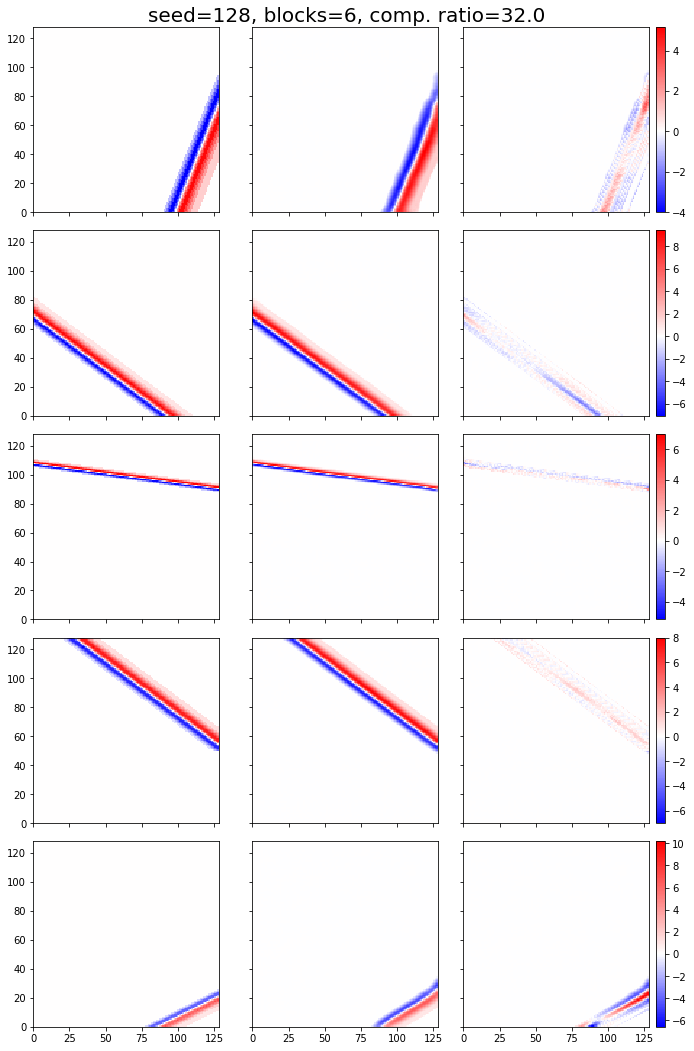

model_pt/notunet_128_6.pt


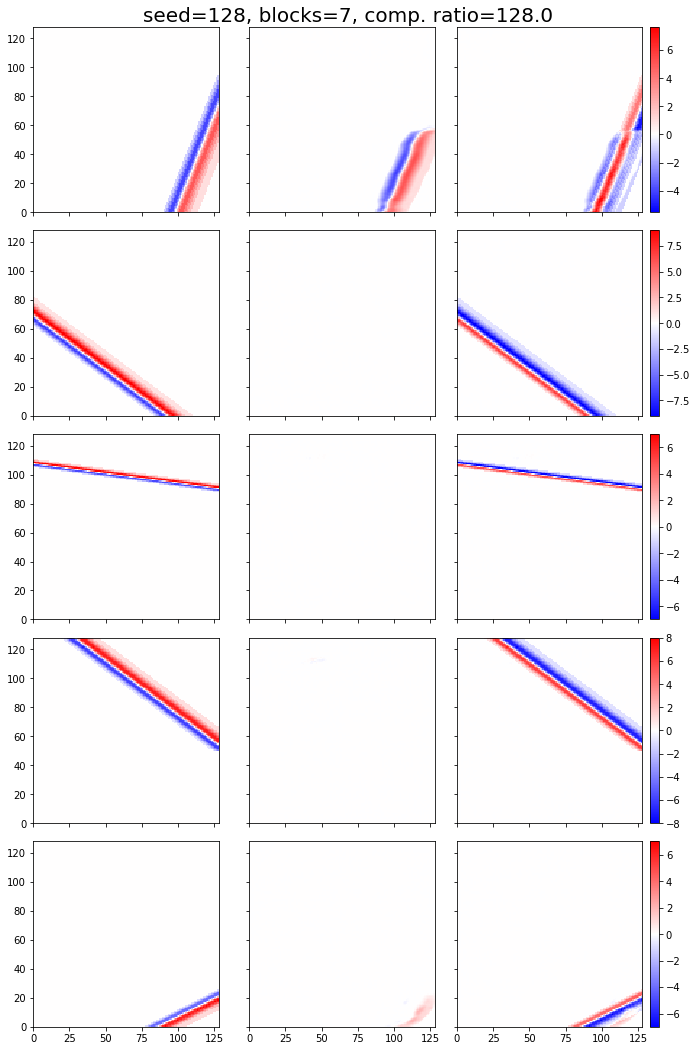

model_pt/notunet_256_4.pt


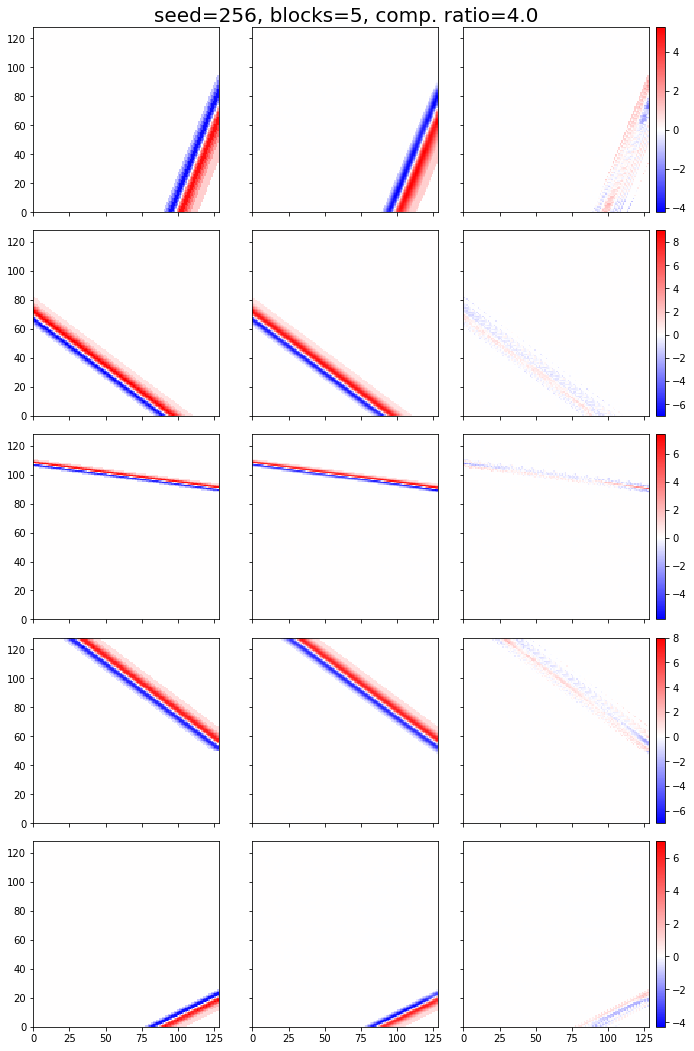

model_pt/notunet_256_5.pt


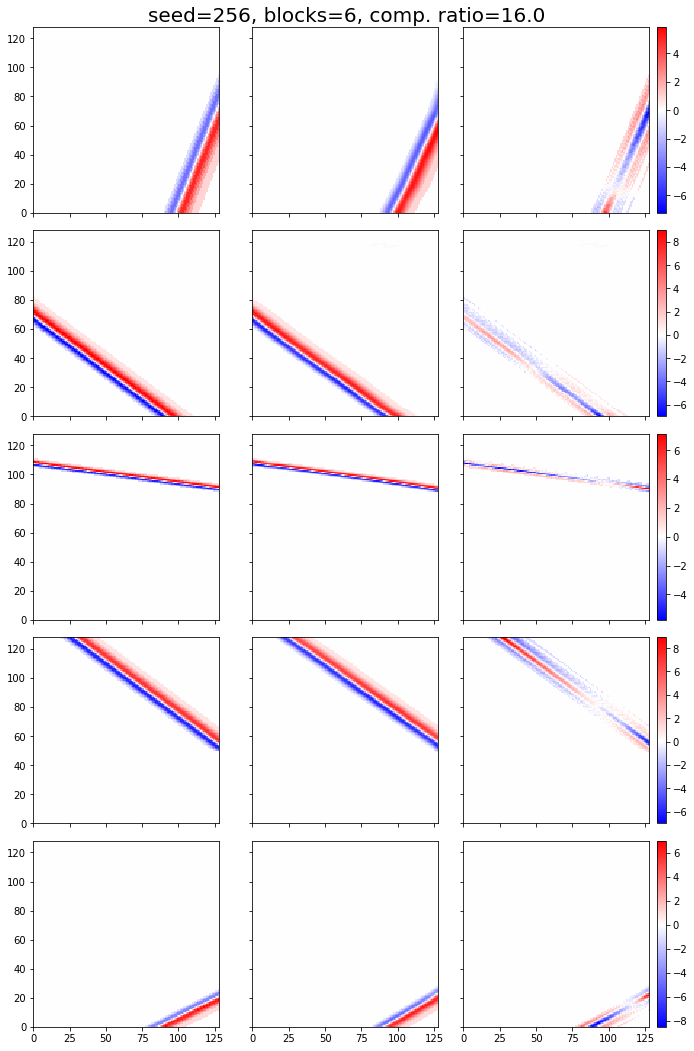

model_pt/notunet_256_6.pt


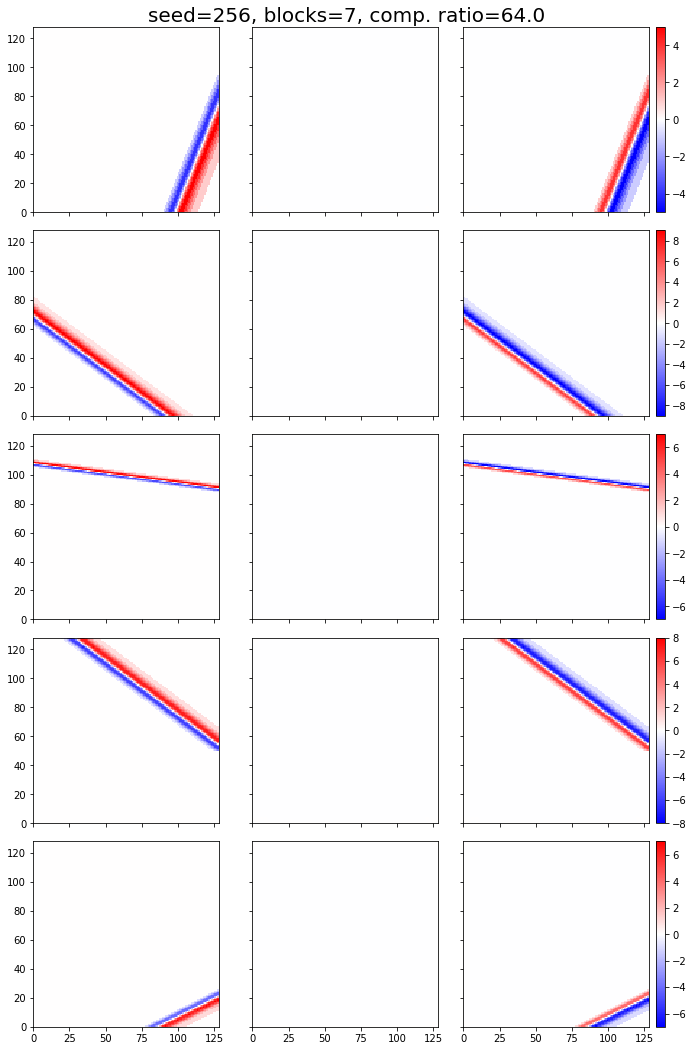

In [20]:
X = next(iter(valid_loader)).cuda()
for model_pt in Path('model_pt').glob('*pt'):
    depth_seed, block = list(map(int, model_pt.stem.split('_')[-2:]))
    compression_ratio = 4**(block + 1) / depth_seed
    if compression_ratio <= 1:
        continue
    print(model_pt)
    save_fname = str(model_pt)[:-3] + '.png'
    title = f"seed={depth_seed}, blocks={block + 1}, comp. ratio={compression_ratio}"
    plot(model_pt, X[:5], save_fname=save_fname, title=title)